In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df_seq = pd.read_csv('../../../../../scratch/kh2383/BIN/BIN_data/chembl_seq.txt', header=None)

In [50]:
len(df_seq)

1870461

In [3]:
df_seq[0].values[0]

'Cc1cc(cn1C)c2csc(N=C(N)N)n2'

In [25]:
freq_codes = []

In [26]:
import os
import sys
import inspect
import codecs
import re
import copy
import argparse
import warnings
from collections import defaultdict, Counter

def get_vocabulary(fobj, is_dict=False):
    """Read text and return dictionary that encodes vocabulary
    vocab = Counter()
    for i, line in enumerate(fobj):
        if is_dict:
            try:
                word, count = line.strip('\r\n ').split(' ')
            except:
                print('Failed reading vocabulary file at line {0}: {1}'.format(i, line))
                sys.exit(1)
            vocab[word] += int(count)
        else:
            for word in line.strip('\r\n ').split(' '):
                if word:
                    vocab[word] += 1
        """
    
    vocab = Counter()
    for word in fobj:
        vocab[word] += 1
    return vocab

def update_pair_statistics(pair, changed, stats, indices):
    """Minimally update the indices and frequency of symbol pairs
    if we merge a pair of symbols, only pairs that overlap with occurrences
    of this pair are affected, and need to be updated.
    """
    stats[pair] = 0
    indices[pair] = defaultdict(int)
    first, second = pair
    new_pair = first+second
    for j, word, old_word, freq in changed:

        # find all instances of pair, and update frequency/indices around it
        i = 0
        while True:
            # find first symbol
            try:
                i = old_word.index(first, i)
            except ValueError:
                break
            # if first symbol is followed by second symbol, we've found an occurrence of pair (old_word[i:i+2])
            if i < len(old_word)-1 and old_word[i+1] == second:
                # assuming a symbol sequence "A B C", if "B C" is merged, reduce the frequency of "A B"
                if i:
                    prev = old_word[i-1:i+1]
                    stats[prev] -= freq
                    indices[prev][j] -= 1
                if i < len(old_word)-2:
                    # assuming a symbol sequence "A B C B", if "B C" is merged, reduce the frequency of "C B".
                    # however, skip this if the sequence is A B C B C, because the frequency of "C B" will be reduced by the previous code block
                    if old_word[i+2] != first or i >= len(old_word)-3 or old_word[i+3] != second:
                        nex = old_word[i+1:i+3]
                        stats[nex] -= freq
                        indices[nex][j] -= 1
                i += 2
            else:
                i += 1

        i = 0
        while True:
            try:
                # find new pair
                i = word.index(new_pair, i)
            except ValueError:
                break
            # assuming a symbol sequence "A BC D", if "B C" is merged, increase the frequency of "A BC"
            if i:
                prev = word[i-1:i+1]
                stats[prev] += freq
                indices[prev][j] += 1
            # assuming a symbol sequence "A BC B", if "B C" is merged, increase the frequency of "BC B"
            # however, if the sequence is A BC BC, skip this step because the count of "BC BC" will be incremented by the previous code block
            if i < len(word)-1 and word[i+1] != new_pair:
                nex = word[i:i+2]
                stats[nex] += freq
                indices[nex][j] += 1
            i += 1


def get_pair_statistics(vocab):
    """Count frequency of all symbol pairs, and create index"""

    # data structure of pair frequencies
    stats = defaultdict(int)

    #index from pairs to words
    indices = defaultdict(lambda: defaultdict(int))

    for i, (word, freq) in enumerate(vocab):
        prev_char = word[0]
        for char in word[1:]:
            stats[prev_char, char] += freq
            indices[prev_char, char][i] += 1
            prev_char = char

    return stats, indices


def replace_pair(pair, vocab, indices):
    """Replace all occurrences of a symbol pair ('A', 'B') with a new symbol 'AB'"""
    first, second = pair
    pair_str = ''.join(pair)
    pair_str = pair_str.replace('\\','\\\\')
    changes = []
    pattern = re.compile(r'(?<!\S)' + re.escape(first + ' ' + second) + r'(?!\S)')
    if sys.version_info < (3, 0):
        iterator = indices[pair].iteritems()
    else:
        iterator = indices[pair].items()
    for j, freq in iterator:
        if freq < 1:
            continue
        word, freq = vocab[j]
        new_word = ' '.join(word)
        new_word = pattern.sub(pair_str, new_word)
        new_word = tuple(new_word.split(' '))

        vocab[j] = (new_word, freq)
        changes.append((j, new_word, word, freq))

    return changes

def prune_stats(stats, big_stats, threshold):
    """Prune statistics dict for efficiency of max()
    The frequency of a symbol pair never increases, so pruning is generally safe
    (until we the most frequent pair is less frequent than a pair we previously pruned)
    big_stats keeps full statistics for when we need to access pruned items
    """
    for item,freq in list(stats.items()):
        if freq < threshold:
            del stats[item]
            if freq < 0:
                big_stats[item] += freq
            else:
                big_stats[item] = freq


def learn_bpe(infile, outfile, num_symbols, min_frequency=2, verbose=False, is_dict=False, total_symbols=False):
    """Learn num_symbols BPE operations from vocabulary, and write to outfile.
    """

    # version 0.2 changes the handling of the end-of-word token ('</w>');
    # version numbering allows bckward compatibility
    outfile.write('#version: 0.2\n')

    vocab = get_vocabulary(infile, is_dict)
    vocab = dict([(tuple(x[:-1])+(x[-1]+'</w>',) ,y) for (x,y) in vocab.items()])
    sorted_vocab = sorted(vocab.items(), key=lambda x: x[1], reverse=True)

    stats, indices = get_pair_statistics(sorted_vocab)
    big_stats = copy.deepcopy(stats)

    if total_symbols:
        uniq_char_internal = set()
        uniq_char_final = set()
        for word in vocab:
            for char in word[:-1]:
                uniq_char_internal.add(char)
            uniq_char_final.add(word[-1])
        sys.stderr.write('Number of word-internal characters: {0}\n'.format(len(uniq_char_internal)))
        sys.stderr.write('Number of word-final characters: {0}\n'.format(len(uniq_char_final)))
        sys.stderr.write('Reducing number of merge operations by {0}\n'.format(len(uniq_char_internal) + len(uniq_char_final)))
        num_symbols -= len(uniq_char_internal) + len(uniq_char_final)
        for i in uniq_char_internal:
            vocab_index2units2freq[i] = 0

    # threshold is inspired by Zipfian assumption, but should only affect speed
    threshold = max(stats.values()) / 10
    for i in range(num_symbols):
        if stats:
            most_frequent = max(stats, key=lambda x: (stats[x], x))

        # we probably missed the best pair because of pruning; go back to full statistics
        if not stats or (i and stats[most_frequent] < threshold):
            prune_stats(stats, big_stats, threshold)
            stats = copy.deepcopy(big_stats)
            most_frequent = max(stats, key=lambda x: (stats[x], x))
            # threshold is inspired by Zipfian assumption, but should only affect speed
            threshold = stats[most_frequent] * i/(i+10000.0)
            prune_stats(stats, big_stats, threshold)

        if stats[most_frequent] < min_frequency:
            sys.stderr.write('no pair has frequency >= {0}. Stopping\n'.format(min_frequency))
            break
        
        #essential
        s1 = most_frequent[0].replace('</w>','')
        s2 = most_frequent[1].replace('</w>','')
        
        vocab_index2units2freq[s1+s2] = stats[most_frequent]
        
        if verbose:
            sys.stderr.write('pair {0}: {1} {2} -> {1}{2} (frequency {3})\n'.format(i, most_frequent[0], most_frequent[1], stats[most_frequent]))
        outfile.write('{0} {1}\n'.format(*most_frequent))
        freq_codes.append(most_frequent)
        changes = replace_pair(most_frequent, sorted_vocab, indices)
        update_pair_statistics(most_frequent, changes, stats, indices)
        stats[most_frequent] = 0
        if not i % 100:
            prune_stats(stats, big_stats, threshold)

In [28]:
vocab_index2units2freq = {}
seq = (df_seq[0].values)
output = open('./drug_codes_chembl_freq_1500.txt', 'w+')
learn_bpe(seq, output, 30000, min_frequency=1500, verbose=True, is_dict=False, total_symbols=True)

Number of word-internal characters: 59
Number of word-final characters: 20
Reducing number of merge operations by 79
pair 0: c c -> cc (frequency 10073898)
pair 1: C C -> CC (frequency 5169755)
pair 2: O ) -> O) (frequency 4100218)
pair 3: ( = -> (= (frequency 3446289)
pair 4: (= O) -> (=O) (frequency 3146255)
pair 5: cc c -> ccc (frequency 2546300)
pair 6: ( C -> (C (frequency 2451909)
pair 7: C (=O) -> C(=O) (frequency 2105699)
pair 8: [ C -> [C (frequency 1976339)
pair 9: [C @ -> [C@ (frequency 1970269)
pair 10: H ] -> H] (frequency 1931599)
pair 11: c 1 -> c1 (frequency 1553909)
pair 12: ) c -> )c (frequency 1385253)
pair 13: (C ) -> (C) (frequency 1096944)
pair 14: c 2 -> c2 (frequency 1077315)
pair 15: cc ccc -> ccccc (frequency 973612)
pair 16: [C@ @ -> [C@@ (frequency 962492)
pair 17: [C@ H] -> [C@H] (frequency 889422)
pair 18: c 3 -> c3 (frequency 874936)
pair 19: [C@@ H] -> [C@@H] (frequency 849974)
pair 20: ccc ( -> ccc( (frequency 829278)
pair 21: ( CC -> (CC (frequency 726

pair 189: =C (C -> =C(C (frequency 49720)
pair 190: NC(=O) N -> NC(=O)N (frequency 49568)
pair 191: C(=O) O) -> C(=O)O) (frequency 48614)
pair 192: (Cl ) -> (Cl) (frequency 48527)
pair 193: ccc 3 -> ccc3 (frequency 48514)
pair 194: (Cl )c -> (Cl)c (frequency 48318)
pair 195: Cl . -> Cl. (frequency 48119)
pair 196: c2 cc( -> c2cc( (frequency 47615)
pair 197: c 1</w> -> c1</w> (frequency 47598)
pair 198: (C) (C) -> (C)(C) (frequency 47214)
pair 199: \C (=C -> \C(=C (frequency 46863)
pair 200: 2 )C -> 2)C (frequency 46639)
pair 201: [C@@H] 2 -> [C@@H]2 (frequency 46295)
pair 202: CCN (C -> CCN(C (frequency 46182)
pair 203: N (CC -> N(CC (frequency 46069)
pair 204: n c1 -> nc1 (frequency 45658)
pair 205: CN C -> CNC (frequency 45538)
pair 206: c4 ccc -> c4ccc (frequency 44714)
pair 207: ccccc 4</w> -> ccccc4</w> (frequency 44549)
pair 208: c2ccccc 2) -> c2ccccc2) (frequency 44351)
pair 209: ccc 2 -> ccc2 (frequency 43633)
pair 210: C(=O) O</w> -> C(=O)O</w> (frequency 43631)
pair 211: 3 )C

pair 370: C c1ccc( -> Cc1ccc( (frequency 19119)
pair 371: c2ccc (Cl)cc -> c2ccc(Cl)cc (frequency 18981)
pair 372: )C(=O) O</w> -> )C(=O)O</w> (frequency 18941)
pair 373: 3)c4 ccccc4 -> 3)c4ccccc4 (frequency 18938)
pair 374: c 2</w> -> c2</w> (frequency 18881)
pair 375: OC )c(OC -> OC)c(OC (frequency 18859)
pair 376: NC(=O) CC -> NC(=O)CC (frequency 18728)
pair 377: OC 1 -> OC1 (frequency 18663)
pair 378: c2ccc(cc 2) -> c2ccc(cc2) (frequency 18492)
pair 379: # C -> #C (frequency 18453)
pair 380: 3CC OCC -> 3CCOCC (frequency 18398)
pair 381: OC) c1 -> OC)c1 (frequency 18374)
pair 382: [C@H] 4 -> [C@H]4 (frequency 18337)
pair 383: CO c1ccc(cc1) -> COc1ccc(cc1) (frequency 18271)
pair 384: c4 ccc(cc -> c4ccc(cc (frequency 18227)
pair 385: n c(C -> nc(C (frequency 18215)
pair 386: [O-] [N+](=O) -> [O-][N+](=O) (frequency 18213)
pair 387: \C(=C \ -> \C(=C\ (frequency 17980)
pair 388: )cc 2 -> )cc2 (frequency 17887)
pair 389: 1 )C -> 1)C (frequency 17768)
pair 390: [C@@H] 4 -> [C@@H]4 (frequen

pair 545: ccc( O)cc -> ccc(O)cc (frequency 11588)
pair 546: )c (O) -> )c(O) (frequency 11585)
pair 547: C(=O)N CC -> C(=O)NCC (frequency 11553)
pair 548: [C@@H](O) C -> [C@@H](O)C (frequency 11545)
pair 549: C c1ccc(cc1) -> Cc1ccc(cc1) (frequency 11438)
pair 550: ) S(=O)(=O)N -> )S(=O)(=O)N (frequency 11427)
pair 551: c4ccc( F)cc -> c4ccc(F)cc (frequency 11338)
pair 552: [C@@H] 3C -> [C@@H]3C (frequency 11259)
pair 553: cc( c1 -> cc(c1 (frequency 11223)
pair 554: c2 c[nH] -> c2c[nH] (frequency 11223)
pair 555: 6 CC -> 6CC (frequency 11170)
pair 556: (C)C )C -> (C)C)C (frequency 11151)
pair 557: =C(N) N) -> =C(N)N) (frequency 11148)
pair 558: n 1) -> n1) (frequency 11100)
pair 559: O [C@H]( -> O[C@H]( (frequency 11092)
pair 560: c3cccc( c3 -> c3cccc(c3 (frequency 11078)
pair 561: N ( -> N( (frequency 11072)
pair 562: ( [O-] -> ([O-] (frequency 11049)
pair 563: CC [C@H](C) -> CC[C@H](C) (frequency 11035)
pair 564: CCC (C -> CCC(C (frequency 11028)
pair 565: c (Cl)cc -> c(Cl)cc (frequency

pair 722: s 3</w> -> s3</w> (frequency 7864)
pair 723: 4 CCC -> 4CCC (frequency 7862)
pair 724: S ) -> S) (frequency 7856)
pair 725: 1 )c3 -> 1)c3 (frequency 7852)
pair 726: CCC(CC 1) -> CCC(CC1) (frequency 7847)
pair 727: c3ccc( O)cc -> c3ccc(O)cc (frequency 7823)
pair 728: c3ccccc2 3) -> c3ccccc23) (frequency 7803)
pair 729: c (Cl) -> c(Cl) (frequency 7803)
pair 730: O) c(O) -> O)c(O) (frequency 7794)
pair 731: C c1ccc(C -> Cc1ccc(C (frequency 7793)
pair 732: [n+] 1 -> [n+]1 (frequency 7788)
pair 733: (=C (C -> (=C(C (frequency 7748)
pair 734: )c5 ccccc5</w> -> )c5ccccc5</w> (frequency 7743)
pair 735: )c4 ccccc4</w> -> )c4ccccc4</w> (frequency 7719)
pair 736: )cc1 OC</w> -> )cc1OC</w> (frequency 7696)
pair 737: ( N) -> (N) (frequency 7639)
pair 738: \C=C\ C(=O) -> \C=C\C(=O) (frequency 7630)
pair 739: ccccc 7 -> ccccc7 (frequency 7628)
pair 740: c3cccc 4 -> c3cccc4 (frequency 7628)
pair 741: OCC OCC -> OCCOCC (frequency 7608)
pair 742: N1 C(=O) -> N1C(=O) (frequency 7604)
pair 743: \

pair 893: c3ccc(cc 3)C -> c3ccc(cc3)C (frequency 6070)
pair 894: N c1n -> Nc1n (frequency 6066)
pair 895: c2ccccc1 2) -> c2ccccc12) (frequency 6061)
pair 896: CCN 1C -> CCN1C (frequency 6057)
pair 897: )c3 ccc( -> )c3ccc( (frequency 6049)
pair 898: (O) CC -> (O)CC (frequency 6037)
pair 899: B r</w> -> Br</w> (frequency 6033)
pair 900: [C@H] 6 -> [C@H]6 (frequency 6032)
pair 901: cccc 2 -> cccc2 (frequency 6020)
pair 902: c3ccc (C -> c3ccc(C (frequency 5996)
pair 903: cn c( -> cnc( (frequency 5986)
pair 904: N CCCC -> NCCCC (frequency 5984)
pair 905: Cl. Cl. -> Cl.Cl. (frequency 5978)
pair 906: [S +] -> [S+] (frequency 5959)
pair 907: O)cc 1</w> -> O)cc1</w> (frequency 5956)
pair 908: )c2 C -> )c2C (frequency 5945)
pair 909: n o -> no (frequency 5923)
pair 910: . OC(=O) -> .OC(=O) (frequency 5922)
pair 911: C [C@H]1 -> C[C@H]1 (frequency 5920)
pair 912: c1ccc( NC(=O) -> c1ccc(NC(=O) (frequency 5919)
pair 913: C (C -> C(C (frequency 5915)
pair 914: nn ( -> nn( (frequency 5906)
pair 915: 

pair 1066: C [C@@H]( -> C[C@@H]( (frequency 4747)
pair 1067: =CC(=O) C -> =CC(=O)C (frequency 4745)
pair 1068: s 3) -> s3) (frequency 4731)
pair 1069: cc 6 -> cc6 (frequency 4728)
pair 1070: c2 occc -> c2occc (frequency 4727)
pair 1071: )C(F)(F) F)cc -> )C(F)(F)F)cc (frequency 4727)
pair 1072: CCC NC(=O) -> CCCNC(=O) (frequency 4722)
pair 1073: 4)c5 ccccc5</w> -> 4)c5ccccc5</w> (frequency 4707)
pair 1074: [n+] 2 -> [n+]2 (frequency 4704)
pair 1075: c3 c(C) -> c3c(C) (frequency 4696)
pair 1076: 1) C(=O)C -> 1)C(=O)C (frequency 4692)
pair 1077: nc2 c1 -> nc2c1 (frequency 4677)
pair 1078: )CC 2</w> -> )CC2</w> (frequency 4666)
pair 1079: CCO c1ccc( -> CCOc1ccc( (frequency 4665)
pair 1080: c (Cl)c -> c(Cl)c (frequency 4664)
pair 1081: \C=C(/C )\ -> \C=C(/C)\ (frequency 4659)
pair 1082: 1=C (C) -> 1=C(C) (frequency 4658)
pair 1083: 4 )c1</w> -> 4)c1</w> (frequency 4654)
pair 1084: c3cc ncc -> c3ccncc (frequency 4653)
pair 1085: CC 2</w> -> CC2</w> (frequency 4653)
pair 1086: O[C@H]( [C@H](O

pair 1231: O [C@@H]2 -> O[C@@H]2 (frequency 3974)
pair 1232: NC(=O)[C@H](C c1ccccc1) -> NC(=O)[C@H](Cc1ccccc1) (frequency 3972)
pair 1233: CC 1CC -> CC1CC (frequency 3972)
pair 1234: c3cc (C) -> c3cc(C) (frequency 3969)
pair 1235: ) [N+](=O)[O-]</w> -> )[N+](=O)[O-]</w> (frequency 3962)
pair 1236: c1 O</w> -> c1O</w> (frequency 3959)
pair 1237: c2ccc( OC -> c2ccc(OC (frequency 3954)
pair 1238: CCCC (=O)N -> CCCC(=O)N (frequency 3951)
pair 1239: occc 4</w> -> occc4</w> (frequency 3942)
pair 1240: c2ccc( N -> c2ccc(N (frequency 3940)
pair 1241: COc1cc cc2 -> COc1cccc2 (frequency 3938)
pair 1242: c5 ccc(F)cc -> c5ccc(F)cc (frequency 3929)
pair 1243: OCC 1 -> OCC1 (frequency 3927)
pair 1244: O [C@@H](C -> O[C@@H](C (frequency 3927)
pair 1245: =C (C)C -> =C(C)C (frequency 3927)
pair 1246: cc( nn -> cc(nn (frequency 3925)
pair 1247: =C( N -> =C(N (frequency 3917)
pair 1248: c( NC -> c(NC (frequency 3916)
pair 1249: c2 c(O) -> c2c(O) (frequency 3913)
pair 1250: [C@H] 8 -> [C@H]8 (frequency 39

pair 1397: [C@@H] 5C -> [C@@H]5C (frequency 3425)
pair 1398: ( nn -> (nn (frequency 3423)
pair 1399: O=C( NC -> O=C(NC (frequency 3422)
pair 1400: (=C ( -> (=C( (frequency 3422)
pair 1401: cc(C) c1 -> cc(C)c1 (frequency 3420)
pair 1402: CN(C (=O) -> CN(C(=O) (frequency 3419)
pair 1403: [C@H](C c1ccccc1) -> [C@H](Cc1ccccc1) (frequency 3417)
pair 1404: c3cc (Cl) -> c3cc(Cl) (frequency 3405)
pair 1405: )c n1</w> -> )cn1</w> (frequency 3402)
pair 1406: CO P(=O)(O) -> COP(=O)(O) (frequency 3393)
pair 1407: C [N+] -> C[N+] (frequency 3393)
pair 1408: CCCC CCC -> CCCCCCC (frequency 3392)
pair 1409: c1 s -> c1s (frequency 3387)
pair 1410: c6 ccccc5 -> c6ccccc5 (frequency 3385)
pair 1411: (C) (C)CC -> (C)(C)CC (frequency 3381)
pair 1412: nn c1 -> nnc1 (frequency 3380)
pair 1413: cc( F) -> cc(F) (frequency 3376)
pair 1414: 4 )C2 -> 4)C2 (frequency 3375)
pair 1415: #N )c3 -> #N)c3 (frequency 3373)
pair 1416: NC(=O)[C@H](C c2ccccc2) -> NC(=O)[C@H](Cc2ccccc2) (frequency 3368)
pair 1417: c %10 -> c%

pair 1560: O c4ccccc4 -> Oc4ccccc4 (frequency 2964)
pair 1561: c3ccc s -> c3cccs (frequency 2962)
pair 1562: COc1ccc(cc1) S(=O)(=O)N -> COc1ccc(cc1)S(=O)(=O)N (frequency 2962)
pair 1563: nn [nH] -> nn[nH] (frequency 2960)
pair 1564: c1n c(C -> c1nc(C (frequency 2954)
pair 1565: c2ccc3 c( -> c2ccc3c( (frequency 2951)
pair 1566: =C(C (=O)N -> =C(C(=O)N (frequency 2946)
pair 1567: 3C 1=O</w> -> 3C1=O</w> (frequency 2945)
pair 1568: c5ccccc4 5</w> -> c5ccccc45</w> (frequency 2943)
pair 1569: c3 ncn -> c3ncn (frequency 2943)
pair 1570: =C(C (=O)O)C(=O) -> =C(C(=O)O)C(=O) (frequency 2942)
pair 1571: cn 3 -> cn3 (frequency 2941)
pair 1572: N3 CCC(CC -> N3CCC(CC (frequency 2941)
pair 1573: CO c1ccccc1C -> COc1ccccc1C (frequency 2941)
pair 1574: cc(Cl) ccc3 -> cc(Cl)ccc3 (frequency 2939)
pair 1575: %1 2 -> %12 (frequency 2939)
pair 1576: 5 )C(=O) -> 5)C(=O) (frequency 2931)
pair 1577: [C@]3 (C)C -> [C@]3(C)C (frequency 2928)
pair 1578: c2cccc (C -> c2cccc(C (frequency 2927)
pair 1579: O c2ccc( 

pair 1723: c4ccc( OC)cc -> c4ccc(OC)cc (frequency 2608)
pair 1724: (Cl )c5 -> (Cl)c5 (frequency 2606)
pair 1725: [C@H](O) CC -> [C@H](O)CC (frequency 2605)
pair 1726: N c2cc( -> Nc2cc( (frequency 2605)
pair 1727: Cl c1cc -> Clc1cc (frequency 2604)
pair 1728: S 2 -> S2 (frequency 2602)
pair 1729: OC )N -> OC)N (frequency 2602)
pair 1730: O[C@@H] 1C -> O[C@@H]1C (frequency 2600)
pair 1731: c4ccccc3 4) -> c4ccccc34) (frequency 2599)
pair 1732: )C(=O) O -> )C(=O)O (frequency 2599)
pair 1733: C(=O)O) C(=O)O</w> -> C(=O)O)C(=O)O</w> (frequency 2597)
pair 1734: n1 )c3 -> n1)c3 (frequency 2596)
pair 1735: N4 CCCC -> N4CCCC (frequency 2593)
pair 1736: cc nc1 -> ccnc1 (frequency 2591)
pair 1737: SC (=S)N -> SC(=S)N (frequency 2591)
pair 1738: )c 5</w> -> )c5</w> (frequency 2590)
pair 1739: cc1 C -> cc1C (frequency 2589)
pair 1740: NC1 =N -> NC1=N (frequency 2587)
pair 1741: ) O -> )O (frequency 2582)
pair 1742: OCC (O) -> OCC(O) (frequency 2577)
pair 1743: N2 CCCCC -> N2CCCCC (frequency 2575)
pa

pair 1889: O c3ccccc3 -> Oc3ccccc3 (frequency 2314)
pair 1890: N 4C -> N4C (frequency 2311)
pair 1891: COc1ccccc1 N2CCN(CC -> COc1ccccc1N2CCN(CC (frequency 2309)
pair 1892: c2ccc3ccccc3 c2 -> c2ccc3ccccc3c2 (frequency 2307)
pair 1893: SSC [C@H]( -> SSC[C@H]( (frequency 2307)
pair 1894: NC(=O)[C@H](CCCCN )NC(=O) -> NC(=O)[C@H](CCCCN)NC(=O) (frequency 2306)
pair 1895: [C@H] (C)CC -> [C@H](C)CC (frequency 2305)
pair 1896: c4c[nH] c5ccccc4 -> c4c[nH]c5ccccc4 (frequency 2303)
pair 1897: 6 CCC -> 6CCC (frequency 2303)
pair 1898: CCN(CC )C(=O) -> CCN(CC)C(=O) (frequency 2302)
pair 1899: 2CCN(CC 2)S(=O)(=O) -> 2CCN(CC2)S(=O)(=O) (frequency 2302)
pair 1900: c3ccc nc3</w> -> c3cccnc3</w> (frequency 2300)
pair 1901: nc3 C -> nc3C (frequency 2299)
pair 1902: l ) -> l) (frequency 2297)
pair 1903: C [C@@H]1C -> C[C@@H]1C (frequency 2296)
pair 1904: C(=O)N )NC(=O) -> C(=O)N)NC(=O) (frequency 2295)
pair 1905: S(=O)(=O) CC -> S(=O)(=O)CC (frequency 2293)
pair 1906: cc( ccc1 -> cc(ccc1 (frequency 2291)


pair 2048: NC(=O) c2ccc( -> NC(=O)c2ccc( (frequency 2081)
pair 2049: c2ccc (Cl)c(Cl)c -> c2ccc(Cl)c(Cl)c (frequency 2079)
pair 2050: \N=C( /C -> \N=C(/C (frequency 2077)
pair 2051: c3cc(Cl) ccc3 -> c3cc(Cl)ccc3 (frequency 2076)
pair 2052: 5 C(=O) -> 5C(=O) (frequency 2075)
pair 2053: N) N -> N)N (frequency 2074)
pair 2054: c2 oc(cc -> c2oc(cc (frequency 2072)
pair 2055: O)cc 3 -> O)cc3 (frequency 2072)
pair 2056: 6 CCCCC -> 6CCCCC (frequency 2072)
pair 2057: n 4C -> n4C (frequency 2071)
pair 2058: c4ccc s -> c4cccs (frequency 2071)
pair 2059: nc (CC -> nc(CC (frequency 2070)
pair 2060: 3CCN(CC 3)C(=O) -> 3CCN(CC3)C(=O) (frequency 2070)
pair 2061: c2ccc (Cl)c -> c2ccc(Cl)c (frequency 2069)
pair 2062: ( NC(=O)C -> (NC(=O)C (frequency 2067)
pair 2063: n2 C</w> -> n2C</w> (frequency 2066)
pair 2064: SC 1 -> SC1 (frequency 2065)
pair 2065: CC NC(=O)N -> CCNC(=O)N (frequency 2065)
pair 2066: NC(=O)OC (C)(C)C -> NC(=O)OC(C)(C)C (frequency 2064)
pair 2067: N 4CC -> N4CC (frequency 2064)
pair 2

pair 2214: \C(=N/ O)\ -> \C(=N/O)\ (frequency 1877)
pair 2215: 1) \ -> 1)\ (frequency 1877)
pair 2216: [nH] nc( -> [nH]nc( (frequency 1876)
pair 2217: O c5 -> Oc5 (frequency 1874)
pair 2218: F)cc 1</w> -> F)cc1</w> (frequency 1874)
pair 2219: 4 )cc3</w> -> 4)cc3</w> (frequency 1874)
pair 2220: 2 3</w> -> 23</w> (frequency 1874)
pair 2221: c(C )c( -> c(C)c( (frequency 1873)
pair 2222: c4cc( O) -> c4cc(O) (frequency 1872)
pair 2223: CC S(=O)(=O)N -> CCS(=O)(=O)N (frequency 1872)
pair 2224: ccccc 7</w> -> ccccc7</w> (frequency 1871)
pair 2225: \C(=C\ CC -> \C(=C\CC (frequency 1871)
pair 2226: OC )C(=O) -> OC)C(=O) (frequency 1871)
pair 2227: )C(=O)N[C@@H](CC (=O)N -> )C(=O)N[C@@H](CC(=O)N (frequency 1870)
pair 2228: c4 ccccc14</w> -> c4ccccc14</w> (frequency 1868)
pair 2229: ccc(F)cc 5</w> -> ccc(F)cc5</w> (frequency 1867)
pair 2230: [C@@H]3CC CN3C(=O) -> [C@@H]3CCCN3C(=O) (frequency 1867)
pair 2231: c1ncc cc1 -> c1ncccc1 (frequency 1866)
pair 2232: cc( OC) -> cc(OC) (frequency 1865)
pair

pair 2373: \C=C \C=C\ -> \C=C\C=C\ (frequency 1722)
pair 2374: N (C)C</w> -> N(C)C</w> (frequency 1721)
pair 2375: 2)C(=O)NC 1=O</w> -> 2)C(=O)NC1=O</w> (frequency 1720)
pair 2376: NC(=O) c3cc( -> NC(=O)c3cc( (frequency 1719)
pair 2377: [C@@]4 (C)CC -> [C@@]4(C)CC (frequency 1718)
pair 2378: CC OC -> CCOC (frequency 1718)
pair 2379: c1C #N</w> -> c1C#N</w> (frequency 1717)
pair 2380: CN(CC C -> CN(CCC (frequency 1717)
pair 2381: 4CC5CC(CC(C 5)C -> 4CC5CC(CC(C5)C (frequency 1717)
pair 2382: S2 (=O)=O) -> S2(=O)=O) (frequency 1716)
pair 2383: O c2cc( -> Oc2cc( (frequency 1714)
pair 2384: 1 = -> 1= (frequency 1712)
pair 2385: c1ccccc1 )c2ccccc -> c1ccccc1)c2ccccc (frequency 1711)
pair 2386: CC( NC(=O) -> CC(NC(=O) (frequency 1709)
pair 2387: [C@@H](O) [C@@H](O[C@@H] -> [C@@H](O)[C@@H](O[C@@H] (frequency 1708)
pair 2388: c2ccc3 OCCO -> c2ccc3OCCO (frequency 1707)
pair 2389: (=O)N (C -> (=O)N(C (frequency 1707)
pair 2390: ccccc2 3</w> -> ccccc23</w> (frequency 1706)
pair 2391: C(=O)N CCC ->

pair 2531: S(=O)(=O) O) -> S(=O)(=O)O) (frequency 1585)
pair 2532: n2 ccc3 -> n2ccc3 (frequency 1584)
pair 2533: Cc1cc( ccc1 -> Cc1cc(ccc1 (frequency 1584)
pair 2534: N(C) C(=O)C -> N(C)C(=O)C (frequency 1583)
pair 2535: CC1 =O</w> -> CC1=O</w> (frequency 1583)
pair 2536: 3 (C -> 3(C (frequency 1583)
pair 2537: 1) O -> 1)O (frequency 1583)
pair 2538: 5 CCN(C)CC -> 5CCN(C)CC (frequency 1582)
pair 2539: (CC 2=O) -> (CC2=O) (frequency 1582)
pair 2540: nc( nc1 -> nc(nc1 (frequency 1581)
pair 2541: c2c( [nH] -> c2c([nH] (frequency 1581)
pair 2542: c1 2)c3 -> c12)c3 (frequency 1581)
pair 2543: 2 CO -> 2CO (frequency 1581)
pair 2544: OC(C O)C -> OC(CO)C (frequency 1580)
pair 2545: ( OC(=O) -> (OC(=O) (frequency 1580)
pair 2546: c4 c(C) -> c4c(C) (frequency 1579)
pair 2547: Br) cc( -> Br)cc( (frequency 1579)
pair 2548: [C@]6 (C) -> [C@]6(C) (frequency 1578)
pair 2549: Nc2 nc(N -> Nc2nc(N (frequency 1575)
pair 2550: )C 4 -> )C4 (frequency 1575)
pair 2551: c3ccc(O)cc 3 -> c3ccc(O)cc3 (frequency 

In [3]:
from subword_nmt.apply_bpe import BPE
import codecs 

bpe_codes_fin = codecs.open('./ESPF/drug_codes_chembl_freq_1500.txt')
bpe = BPE(bpe_codes_fin, merges=-1, separator='')

In [8]:
bpe.process_line(df_seq[0].values[100])

'CC(C)C (=C )CC (O)C (C) (O) [C@H]1CC [C@H]2C 3=C [C@H](OC(=O)C) [C@H]4 [C@@H](OC(=O)C) [C@@H](O)CC [C@]4(C)[C@H]3CC [C@]12C'

In [9]:
df_seq[0].values[100]

'CC(C)C(=C)CC(O)C(C)(O)[C@H]1CC[C@H]2C3=C[C@H](OC(=O)C)[C@H]4[C@@H](OC(=O)C)[C@@H](O)CC[C@]4(C)[C@H]3CC[C@]12C'

In [32]:
idx2word = list(vocab_index2units2freq.keys())

In [33]:
words2idx = dict(zip(vocab_index2units2freq.keys(), range(0, len(idx2word))))

In [34]:
word_length_count = defaultdict(int)
for i in range(len(list(vocab_index2units2freq.keys()))):
    word_length_count[len(list(vocab_index2units2freq.keys())[i])] += 1

<BarContainer object of 31 artists>

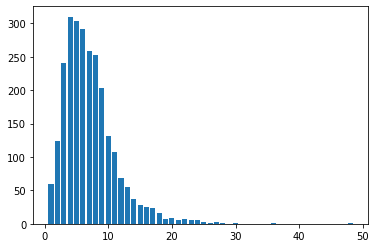

In [35]:
plt.bar(list(word_length_count.keys()), list(word_length_count.values()))

In [36]:
word_length_count

defaultdict(int,
            {1: 59,
             2: 124,
             3: 241,
             4: 310,
             5: 303,
             6: 292,
             7: 259,
             8: 253,
             9: 203,
             10: 131,
             11: 108,
             12: 68,
             13: 55,
             14: 37,
             15: 28,
             16: 25,
             17: 24,
             18: 16,
             19: 7,
             20: 9,
             21: 6,
             22: 7,
             23: 5,
             24: 6,
             25: 3,
             26: 1,
             27: 2,
             28: 1,
             30: 1,
             36: 1,
             48: 1})

In [39]:
sub_csv = pd.DataFrame(list(vocab_index2units2freq.items()),
                      columns=['index','frequency'])
sub_csv.reset_index(level=0, inplace=True)
sub_csv.to_csv('./subword_units_map_chembl_freq_1500.csv')

In [17]:
(sub_csv['index'].values)

array(['V', 'b', 'G', ..., 'c(C)c3', '#N)cc1', 'c5cc6'], dtype=object)